In [1]:
# pip install tensorflow

# NLP - Word2Vec Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). For example consider a simple sentence, “the quick brown fox jumps over the lazy dog”, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. Thus the model tries to predict the target_word based on the context_window words.

In [106]:
import nltk
import numpy as np
from string import punctuation
import re
import tensorflow as tf
from keras.preprocessing import text
import pandas as pd
from keras.utils import pad_sequences
from keras.utils import np_utils

The Word2Vec family of models are unsupervised, which means that one can just give it a corpus without additional labels or information and it can construct dense word embeddings from the corpus. But one still needs to leverage a supervised, classification methodology once corpus is in hand to get to these embeddings. This is done within the corpus itself, without any auxiliary information. I have model this CBOW architecture as a deep learning classification model such that I take in the context words as my input, X and try to predict the target word, Y.

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
with open('raw_text-2.txt',encoding="utf8") as f:
    contents = f.readline()
corpus = [contents]
print(corpus)



['During my second month of nursing school, our professor gave us a pop quiz. I was a conscientious student and had breezed through the questions, until I read the last one: “What is the first name of the woman who cleans the school?”  Surely this was some kind of joke. I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name? I handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade. “Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care, even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.']


First we have to preprocess the raw data. I have defined a function that replaces anything out of the regular alphabet with an empty string. Then strips the whitespaces around it and takes the lower case and the tokenizes the string. Thereafter it removes all standard stop-words as given by nltk and the joins the sentence back and returns it.There after that I have used the python standard function map , map each sentence in the corpus to its clean version.

In [108]:
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def preprocess_document(document):
    document = re.sub(r'[^a-zA-Z\s]', '', document, re.I|re.A)
    document = document.lower().strip()
    tokens = wpt.tokenize(document)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    new_document = ' '.join(filtered_tokens)
    return new_document

preprocess_corpus = np.vectorize(preprocess_document)
preprocessed_corpus = preprocess_corpus(corpus)
preprocessed_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['second month nursing school professor gave us pop quiz conscientious student breezed questions read last one first name woman cleans school surely kind joke seen cleaning woman several times tall darkhaired would know name handed paper leaving last question blank class ended one student asked last question would count toward quiz grade absolutely said professor careers meet many people significant deserve attention care even smile say hello ive never forgotten lesson also learned name dorothy'],
      dtype='<U497')

Then words are encoded to numbers for passing them into the neural network.

In [109]:
tokenizer = text.Tokenizer()
# print(tokenizer)
tokenizer.fit_on_texts(preprocessed_corpus)

word2id_dict = tokenizer.word_index
print(" The dictionary:\n", word2id_dict)
word2id_dict['PAD'] = 0
id2word = {v:k for k, v in word2id_dict.items()}
word_ids = [[word2id_dict[w] for w in text.text_to_word_sequence(doc)] for doc in preprocessed_corpus]
print(word_ids)
vocabulary_size = len(word2id_dict)
print(" \nThe vocabulary size is: ",vocabulary_size,"\n")
embedding_size = 100
window_size = 2 

 The dictionary:
 {'last': 1, 'name': 2, 'school': 3, 'professor': 4, 'quiz': 5, 'student': 6, 'one': 7, 'woman': 8, 'would': 9, 'question': 10, 'second': 11, 'month': 12, 'nursing': 13, 'gave': 14, 'us': 15, 'pop': 16, 'conscientious': 17, 'breezed': 18, 'questions': 19, 'read': 20, 'first': 21, 'cleans': 22, 'surely': 23, 'kind': 24, 'joke': 25, 'seen': 26, 'cleaning': 27, 'several': 28, 'times': 29, 'tall': 30, 'darkhaired': 31, 'know': 32, 'handed': 33, 'paper': 34, 'leaving': 35, 'blank': 36, 'class': 37, 'ended': 38, 'asked': 39, 'count': 40, 'toward': 41, 'grade': 42, 'absolutely': 43, 'said': 44, 'careers': 45, 'meet': 46, 'many': 47, 'people': 48, 'significant': 49, 'deserve': 50, 'attention': 51, 'care': 52, 'even': 53, 'smile': 54, 'say': 55, 'hello': 56, 'ive': 57, 'never': 58, 'forgotten': 59, 'lesson': 60, 'also': 61, 'learned': 62, 'dorothy': 63}
[[11, 12, 13, 3, 4, 14, 15, 16, 5, 17, 6, 18, 19, 20, 1, 7, 21, 2, 8, 22, 3, 23, 24, 25, 26, 27, 8, 28, 29, 30, 31, 9, 32, 2, 

Then we create training samples from the encoded corpus. In the function belo for every word in every sentence of the corpus we cut out the context around it and pair it with the word.

In [112]:
from keras.preprocessing import sequence
from keras.utils import np_utils

def generate_context_word_pairs(corpus, window_size, vocab_size):
    X = []
    Y = []
    context_length = window_size*2
    for words in word_ids:
        sentence_length = len(words)
        for index, word in enumerate(words):           
            start = index - window_size
            end = index + window_size + 1
            context = [words[i] for i in range(start, end)if 0 <= i < sentence_length and i != index]
            x = pad_sequences([context], maxlen=context_length)
            y = np_utils.to_categorical(Y, vocab_size)
            X.append(x)
            Y.append(word)
            # yield (x, y)
    return X,Y

In [111]:
i = 0
for x,y in generate_context_word_pairs(corpus=word_ids, window_size=window_size, vocab_size=vocabulary_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['second', 'month', 'school', 'professor'] -> Target (Y): second
Context (X): ['month', 'nursing', 'professor', 'gave'] -> Target (Y): second
Context (X): ['nursing', 'school', 'gave', 'us'] -> Target (Y): second
Context (X): ['school', 'professor', 'us', 'pop'] -> Target (Y): second
Context (X): ['professor', 'gave', 'pop', 'quiz'] -> Target (Y): second
Context (X): ['gave', 'us', 'quiz', 'conscientious'] -> Target (Y): second
Context (X): ['us', 'pop', 'conscientious', 'student'] -> Target (Y): second
Context (X): ['pop', 'quiz', 'student', 'breezed'] -> Target (Y): second
Context (X): ['quiz', 'conscientious', 'breezed', 'questions'] -> Target (Y): second
Context (X): ['conscientious', 'student', 'questions', 'read'] -> Target (Y): second
Context (X): ['student', 'breezed', 'read', 'last'] -> Target (Y): second


Thereafter I have defined the architecture of the network using the Pytorch. There is an embedding layer with embedding dimension 100 as given in the question which learns the dense vector representations for each word in the vocabulary. The output of this layer is passed to a ReLU activated linear layer of size 128 as given in the question. This is further passed to another linear layer which has a softmax activation.<br>

A layer with a softmax activation always returns a probability distribution. The probability distribution in this case will be a distribution over the vocabulary built earlier. The output tells which which word is most likely to be placed in the centre given a set of context words.

In [97]:
import torch
import torch.nn as nn
import numpy as np

class CBOW(torch.nn.Module):

    def __init__(self, inp_size , vocab_size, embedding_dim=100):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()        
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(torch.from_numpy(inputs).long())).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out
    
model = CBOW(window_size*2,vocabulary_size)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [117]:
print(" The model architecture is:\n", model)

 The model architecture is:
 CBOW(
  (embeddings): Embedding(64, 100)
  (linear1): Linear(in_features=100, out_features=128, bias=True)
  (activation_function1): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (activation_function2): LogSoftmax(dim=-1)
)


After defining the network we train it for 50 epochs against one hot encoded vector of the vocabulary which represents one target word each.

In [113]:
for epoch in range(1, 50):
    loss = 0.
    i = 0
    X,Y = generate_context_word_pairs(corpus=word_ids, window_size=window_size, vocab_size=vocabulary_size)
    for x, y in zip(X,Y):
        i += 1
        optimizer.zero_grad()
        log_probs = model(x[0])
        loss = loss_function(log_probs,torch.Tensor([y]).long())
        loss.backward()
        optimizer.step()
        loss += loss.data
    print('Epoch Number:', epoch, '\tLoss Obtained:', loss)

Epoch Number: 1 	Loss Obtained: tensor(0.5524, grad_fn=<AddBackward0>)
Epoch Number: 2 	Loss Obtained: tensor(0.5257, grad_fn=<AddBackward0>)
Epoch Number: 3 	Loss Obtained: tensor(0.5019, grad_fn=<AddBackward0>)
Epoch Number: 4 	Loss Obtained: tensor(0.4802, grad_fn=<AddBackward0>)
Epoch Number: 5 	Loss Obtained: tensor(0.4596, grad_fn=<AddBackward0>)
Epoch Number: 6 	Loss Obtained: tensor(0.4408, grad_fn=<AddBackward0>)
Epoch Number: 7 	Loss Obtained: tensor(0.4226, grad_fn=<AddBackward0>)
Epoch Number: 8 	Loss Obtained: tensor(0.4059, grad_fn=<AddBackward0>)
Epoch Number: 9 	Loss Obtained: tensor(0.3906, grad_fn=<AddBackward0>)
Epoch Number: 10 	Loss Obtained: tensor(0.3759, grad_fn=<AddBackward0>)
Epoch Number: 11 	Loss Obtained: tensor(0.3623, grad_fn=<AddBackward0>)
Epoch Number: 12 	Loss Obtained: tensor(0.3497, grad_fn=<AddBackward0>)
Epoch Number: 13 	Loss Obtained: tensor(0.3372, grad_fn=<AddBackward0>)
Epoch Number: 14 	Loss Obtained: tensor(0.3258, grad_fn=<AddBackward0>)
E

Viewing the embeddings

In [114]:
embeddings = model.embeddings(torch.Tensor([list(range(0,vocabulary_size))]).long())
pd.DataFrame(embeddings.view(-1,100).tolist(), index=list(id2word.values())[0:])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
last,0.499750,-0.305769,-0.927929,1.023900,1.563820,0.569895,-1.373397,0.288137,0.215902,0.196773,...,0.998101,1.043545,0.909461,-1.639167,-0.078348,-0.450077,0.684774,-1.389842,-0.542943,-0.263892
name,0.045232,1.505606,-0.124120,-0.779188,0.814693,0.129049,-0.643182,1.886962,-0.052576,-0.012889,...,1.283108,0.534946,-0.857594,-0.449904,1.324825,-1.001372,-0.279473,1.049597,0.880716,-1.442898
school,-1.838386,-0.817350,0.035940,1.720654,1.128536,-1.133799,-1.178414,1.614829,1.428062,-0.547181,...,0.513767,1.138487,0.538827,-0.056236,1.581903,-1.311018,0.551752,0.492737,1.105744,-0.906386
professor,-1.575812,-0.851389,0.490099,-0.621855,-1.724083,-0.701167,-0.336879,0.186446,-1.678818,0.253006,...,-0.444509,-0.841905,0.064818,1.236449,1.360319,-1.128636,0.011276,0.864242,-0.222719,-0.222021
quiz,-0.602046,2.597855,-0.255670,-1.850175,0.177136,-1.573290,-0.682176,-1.403996,-0.381959,-0.120449,...,-0.451994,-0.156942,0.263345,-0.267801,0.527081,-1.141582,-1.371199,0.510803,1.334760,-0.068579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lesson,-1.583776,-0.516618,2.734972,-1.245614,-0.515813,0.503297,-0.187408,-0.513411,-0.067672,-0.493100,...,-0.718918,0.096974,-1.034469,1.430752,0.930685,-0.657579,-0.378548,1.052690,-0.287362,-0.257790
also,-1.053110,0.630943,0.716835,0.975766,0.152922,-0.195267,1.470545,1.236399,0.849045,-0.471138,...,-0.715026,-2.273364,1.190260,-1.808686,-0.608847,-0.622449,-1.578839,0.792399,0.908460,1.029104
learned,-0.508999,-0.721901,1.548838,1.608680,-0.231141,0.512928,0.511031,-1.262283,0.271078,-0.824497,...,-0.808691,1.383067,-0.564884,0.776183,1.332688,-0.534636,-0.907525,-0.011413,-0.814135,1.892028
dorothy,0.115834,-0.595812,-0.008467,1.132215,0.057305,0.965457,-0.860552,-0.209786,0.348056,0.991099,...,-1.143720,0.844697,1.021772,0.729919,-1.307861,1.874926,-0.695448,-0.649094,0.108790,-0.493862


In [115]:
from sklearn.metrics.pairwise import euclidean_distances

weights = embeddings.view(-1,100)
distance_matrix = euclidean_distances(weights.detach().numpy())
search_list = ['tall','pop','quiz','never','woman']
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id_dict[search_term]-1].argsort()[1:6]+1] for search_term in search_list }

similar_words

{'tall': ['absolutely', 'care', 'say', 'woman', 'surely'],
 'pop': ['ended', 'blank', 'darkhaired', 'handed', 'nursing'],
 'quiz': ['say', 'read', 'hello', 'significant', 'darkhaired'],
 'never': ['class', 'questions', 'first', 'hello', 'read'],
 'woman': ['darkhaired', 'dorothy', 'absolutely', 'know', 'cleans']}

 visualize the embeddings to understand similarity between the learned word embeddings.

Total words: 30 	Word Embedding shapes: 30


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


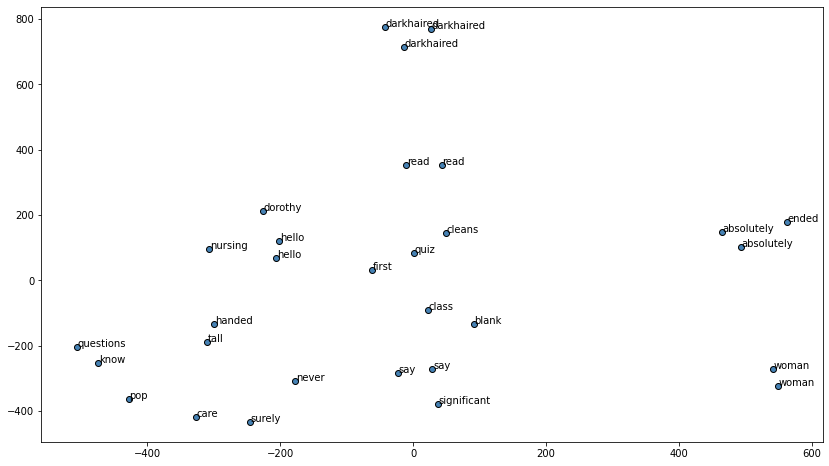

In [116]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id_dict[w] for w in words]
word_vectors = ([weights[idx].detach().numpy() for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', len(word_vectors))

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')